In [2]:
#Load Libraries

import pandas as pd
import numpy as np 
import shap 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

c:\Users\jpodichetty\Anaconda3\envs\shap_env_AS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the dataset correctly using the header row in the CSV
path = "../../Data/cancer/cancer.csv"
data = pd.read_csv(path)  # Removed names=...

# Drop unwanted columns
drop_cols = [
    "sample_id", "patient_cohort", "sample_origin", "age", "sex",
    "stage", "benign_sample_diagnosis", "plasma_CA19_9", "REG1A"
]
clean_data = data.drop(columns=drop_cols)

# Encode diagnosis as categorical codes: will become 0, 1, 2
clean_data["diagnosis"] = clean_data["diagnosis"].astype("category").cat.codes

# Show the cleaned data
print(clean_data.head(10))

   diagnosis  creatinine     LYVE1      REG1B        TFF1
0          0     1.83222  0.893219   52.94884  654.282174
1          0     0.97266  2.037585   94.46703  209.488250
2          0     0.78039  0.145589  102.36600  461.141000
3          0     0.70122  0.002805   60.57900  142.950000
4          0     0.21489  0.000860   65.54000   41.088000
5          0     0.84825  0.003393   62.12600   59.793000
6          0     0.62205  0.174381  152.27700  117.516000
7          0     0.89349  0.003574    3.73000   40.294000
8          0     0.48633  0.001945    7.02100   26.782000
9          0     0.61074  0.278778   83.92800   19.185000


In [3]:
# Encode diagnosis
clean_data["diagnosis"] = clean_data["diagnosis"].astype("category").cat.codes

# Define X and y
X = clean_data.drop("diagnosis", axis=1)
y = clean_data["diagnosis"]

# Binarize labels for ROC-AUC
y_binarized = label_binarize(y, classes=[0, 1, 2])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "SVM": SVC(probability=True),
    "kNN": KNeighborsClassifier()
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    recall = recall_score(y_test, y_pred, average="macro")
    roc_auc = roc_auc_score(y_test_bin, y_proba, average="macro")

    print(f"{name}:")
    print(f"  Recall Score: {recall:.3f}")
    print(f"  ROC-AUC:      {roc_auc:.3f}\n")


Logistic Regression:
  Recall Score: 0.667
  ROC-AUC:      0.828

Random Forest:
  Recall Score: 0.686
  ROC-AUC:      0.826

XGBoost:
  Recall Score: 0.625
  ROC-AUC:      0.814

SVM:
  Recall Score: 0.620
  ROC-AUC:      0.805

kNN:
  Recall Score: 0.588
  ROC-AUC:      0.771



In [4]:
# Dictionary of different models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Linear model
    "Random Forest": RandomForestClassifier(),                 # Tree-based ensemble model
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),  # Boosted trees
    "SVM": SVC(probability=True)  # Support Vector Machine with probability enabled for SHAP
}

# Dictionaries to store SHAP values and interpretability metrics
shap_results = {}       # Stores SHAP values for each model
interpret_scores = {}   # Stores summary interpretability metrics per model

In [5]:
for name, model in models.items():
    print(f"Training and explaining: {name}")
    
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Use TreeExplainer for tree-based models (fast & optimized), otherwise use KernelExplainer
    if name in ["Random Forest", "XGBoost"]:
        explainer = shap.TreeExplainer(model)
    else:
        # For non-tree models (LogReg, SVM), use a subset of training data as background
        background = shap.sample(X_train_scaled, 100, random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)

    # Compute SHAP values for test data
    shap_values = explainer.shap_values(X_test_scaled)

    # If binary classification and shap_values is a list, use class 1 SHAP values
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]  # Use SHAP values for class 1
    else:
        shap_vals = shap_values.values  # For newer SHAP versions returning Explanation object

    # Calculate absolute SHAP values (magnitude of feature impact)
    abs_vals = np.abs(shap_vals)

    # Mean SHAP value magnitude across all features and samples — measures overall impact
    mean_magnitude = np.mean(abs_vals)

    # Sparsity = average number of features with SHAP > 0.01 (how many features "matter" per prediction)
    sparsity = np.mean(np.sum(abs_vals > 0.01, axis=1))

    # Store results
    shap_results[name] = shap_vals
    interpret_scores[name] = {
        "mean_shap_magnitude": mean_magnitude,
        "sparsity": sparsity
    }


Training and explaining: Logistic Regression


100%|██████████| 118/118 [00:02<00:00, 40.56it/s]


Training and explaining: Random Forest
Training and explaining: XGBoost


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Training and explaining: SVM


100%|██████████| 118/118 [00:07<00:00, 15.23it/s]


In [6]:
# Convert the interpretability scores dictionary to a DataFrame and sort by sparsity
# Lower sparsity = simpler model explanations (fewer important features per prediction)
interpret_df = pd.DataFrame(interpret_scores).T.sort_values("sparsity")
interpret_df  # Display the table


,mean_shap_magnitude,sparsity
Logistic Regression,0.056260,3.245763
SVM,0.035349,3.271186
Random Forest,0.059993,3.432203
XGBoost,0.453894,3.932203



Most interpretable model: Logistic Regression


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


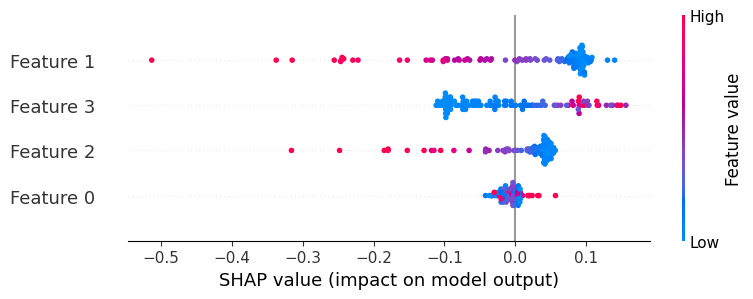

In [7]:
# Get the name of the most interpretable model (lowest sparsity)
best_model_name = interpret_df.index[0]

print(f"\nMost interpretable model: {best_model_name}")

# Plot the SHAP summary plot for that model
# This shows global feature importance and directionality
shap.summary_plot(shap_results[best_model_name], X_test_scaled)


In [8]:
# Detailed SHAP Analysis - Random Forest 
# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# SHAP Explainer (TreeExplainer is fast for tree models)
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test_scaled)

# For binary classification: use class 1 SHAP values
rf_shap = shap_values[1]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


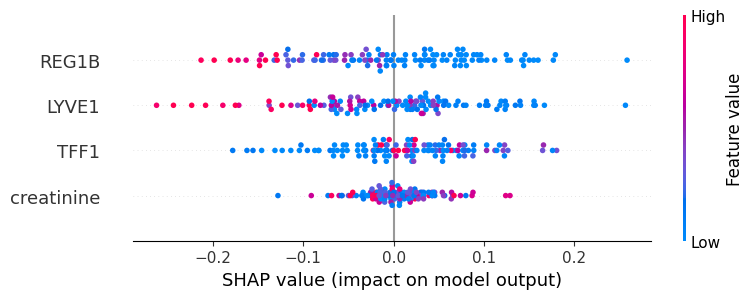

In [ ]:
#Global summary plot
shap.summary_plot(rf_shap, X_test_scaled, feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])
#Shows each feature's overall importance
#Color represents feature value (red = high, blue = low)
#SHAP value (x-axis) shows impact on prediction

Conclusions: 
Higher REG1B levels are associated with higher probability of the positive class (e.g., pancreatic cancer if that's your class 1).

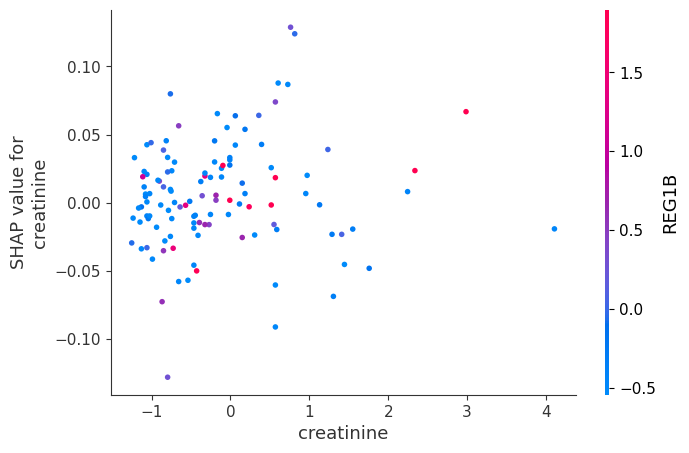

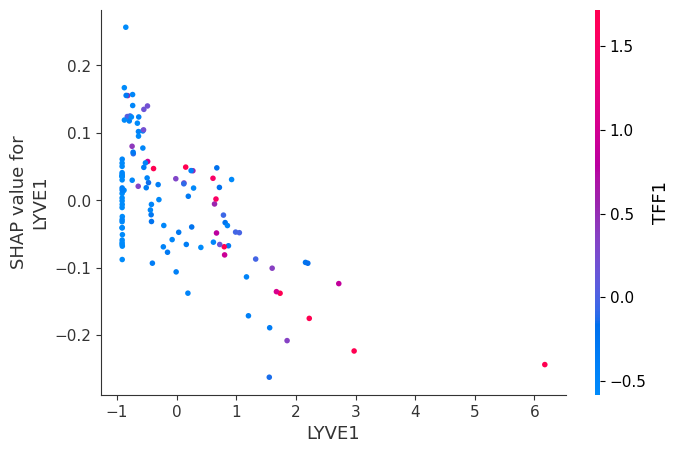

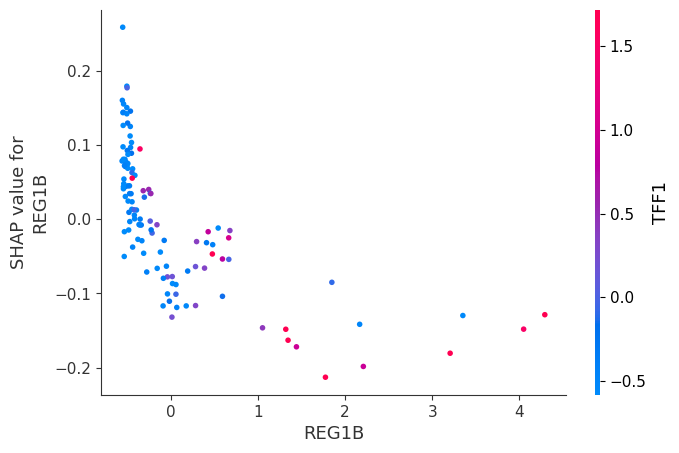

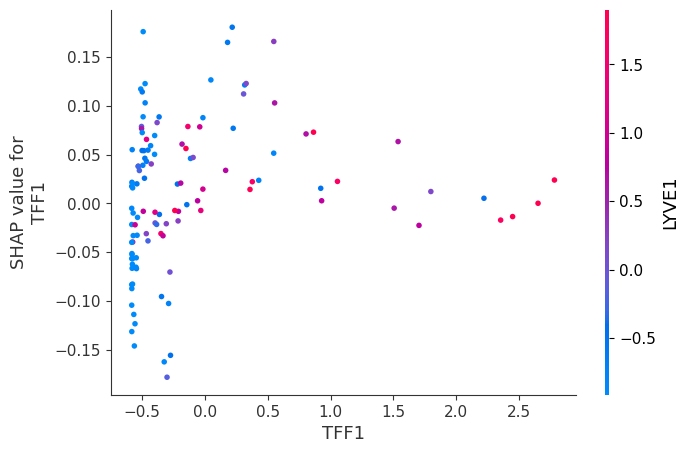

In [10]:
#Dependence Plots (Feature Behavior)
shap.dependence_plot("creatinine", rf_shap, X_test_scaled, feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])
shap.dependence_plot("LYVE1", rf_shap, X_test_scaled, feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])
shap.dependence_plot("REG1B", rf_shap, X_test_scaled, feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])
shap.dependence_plot("TFF1", rf_shap, X_test_scaled, feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])


In [13]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],      # Base value for class 1
    rf_shap[0],                       # SHAP values for the first test instance
    X_test_scaled[0],           # Feature values for the first test instance
    feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"]  # Feature labels
)

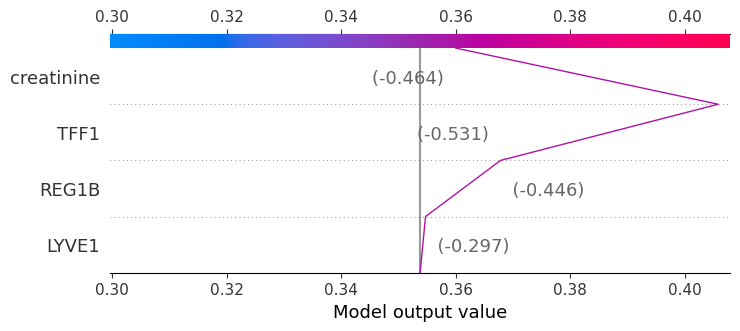

In [15]:
shap.decision_plot(explainer.expected_value[1], rf_shap[0], X_test_scaled[0], feature_names=["creatinine", "LYVE1", "REG1B", "TFF1"])
